# EvoComp, lab 2
*Grigorev Mikhail J4233c*

Dependencies:

In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.3 MB/s eta 0:00:00


Goal: to design an algorithm that would solve [queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) with at least 8x8 board. The script for lab 1 can be used as templete, however modifications for the algorithm to work with a discrete problem are necessary.

Solution encoding and mutation/crossover operator design are important. Visualization of the solution is required at the end of the script.

In [2]:
from itertools import cycle

import math
import random

from multiprocessing import Pool

import pandas as pd
import numpy as np
import numpy.random as rnd

import deap
from deap import tools, base, creator, algorithms

import matplotlib.pyplot as plt

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
class QueensExperiment:
    def __init__(self, queens, fitness_evaluation, pop_size, generations,
                 crossover_rate, mutation_rate, mutation_func):
        gen = lambda: random.choices(range(queens**2), k=queens)

        self.individual_generator = gen
        self.fitness_evaluation = fitness_evaluation
        self.pop_size = pop_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate  = mutation_rate
        self.mutation_func  = mutation_func

        self.toolbox = base.Toolbox()
        self.toolbox.register("individual", tools.initIterate,
                              creator.Individual, self.individual_generator)
        self.toolbox.register("population", tools.initRepeat, list,
                              self.toolbox.individual)

        # fitness evaluation
        indi = lambda individual: (fitness_evaluation(individual),)
        self.toolbox.register("evaluate", indi)

        # mutators
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", mutation_func[0], **mutation_func[1])

        # selection
        self.toolbox.register("select", tools.selTournament, tournsize=4)


    def run(self):
        pop = self.pop_size

        # best fit individual with a hall of fame record
        hof = tools.HallOfFame(3, np.array_equal)

        # generation statistics log
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])

        stats = tools.Statistics(
            key=lambda individual: individual.fitness.values)
        stats.register("std", lambda population: np.std(
            [fitness for fitness in population if fitness[0] != math.inf]))
        stats.register("avg", lambda population: np.mean(
            [fitness for fitness in population if fitness[0] != math.inf]))
        stats.register("min", lambda population: np.min(
            [fitness for fitness in population if fitness[0] != math.inf]))
        stats.register("max", lambda population: np.max(
            [fitness for fitness in population if fitness[0] != math.inf]))

        _, log = algorithms.eaSimple(
            self.toolbox.population(n=pop),
            self.toolbox,
            ngen=generations,
            cxpb=crossover_rate,
            mutpb=mutation_rate,
            stats=stats,
            halloffame=hof,
            verbose=False,
        )

        print("Best = {}".format(hof[0]))
        print("Best fit = {}".format(hof[0].fitness.values[0]))
        return log, hof[0]

In [5]:
def starigin(individual):
    #  removed duplicate values
    if len(individual) != len(set(individual)):
        return math.inf

    dim = len(individual)
    # count all conflict pairs
    fitness: float = 0
    for x in range(len(individual)):
        x_row, x_column = individual[x] // dim, individual[x] % dim
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // dim, individual[y] % dim
            if x_row == y_row or \
            x_column == y_column or \
            abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1

    return fitness

In [7]:
def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return (np.array(gen_list), np.array(avg_list),
            np.array(std_list), np.array(max_list), np.array(min_list))

def draw_log(log):
    c_u, c_r, c_b = "cornflowerblue", "indianred", "black"
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg", color=c_b, linewidth=1)
    plt.plot(gen_list, min_list, label="min", color=c_r, linewidth=1, alpha=0.3)
    plt.plot(gen_list, max_list, label="max", color=c_u, linewidth=1, alpha=0.3)
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.5)
    plt.legend()
    plt.show()

In [8]:
QUEENS_NUMBER = 8
generations = 100
pop_size = 2500
crossover_rate=0.5
mutation_rate=0.5
mutation_func = (
    tools.mutUniformInt,
    {"low": 0, "up": 8**2 - 1, "indpb": 1/4}
)

scenario = QueensExperiment(QUEENS_NUMBER, starigin, pop_size, generations, crossover_rate, mutation_rate, mutation_func)

Best = [19, 39, 41, 14, 52, 29, 58, 0]
Best fit = 0.0


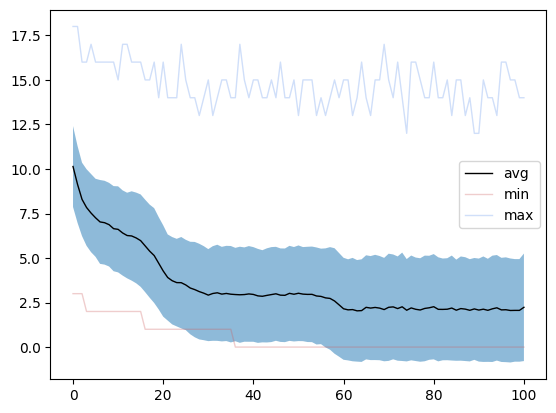

In [9]:
log, fittest = scenario.run()
draw_log(log)

In [11]:
print(f"Positions: {fittest}")
print(f"Duplicates: {len(fittest) - len(set(fittest))}")

Positions: [19, 39, 41, 14, 52, 29, 58, 0]
Duplicates: 0


In [26]:
def display_grid(solution):
    dim = len(solution)
    if dim > 26:
        print("No way to label")

    if dim % 2 != 0:
        arr = ["⬛" if i%2!=0 else "⬜" for i in range(dim**2)]
    else:
        odd = ["⬛" if i%2!=0 else "⬜" for i in range(dim)]
        eve = ["⬛" if i%2==0 else "⬜" for i in range(dim)]
        arr = []
        for i in range(dim):
            if i%2==0:
                arr.extend(odd)
            else:
                arr.extend(eve)
    for queen in solution:
        arr[queen] = "👑"
    arr = np.array(arr)
    arr = arr.reshape((dim, dim))

    df = pd.DataFrame(data=arr, index=range(1, len(arr)+1),
                      columns=list(map(chr, range(97, 123)))[:dim])
    return df

display_grid(fittest)

,a,b,c,d,e,f,g,h
1,👑,⬛,⬜,⬛,⬜,⬛,⬜,⬛
2,⬛,⬜,⬛,⬜,⬛,⬜,👑,⬜
3,⬜,⬛,⬜,👑,⬜,⬛,⬜,⬛
4,⬛,⬜,⬛,⬜,⬛,👑,⬛,⬜
5,⬜,⬛,⬜,⬛,⬜,⬛,⬜,👑
6,⬛,👑,⬛,⬜,⬛,⬜,⬛,⬜
7,⬜,⬛,⬜,⬛,👑,⬛,⬜,⬛
8,⬛,⬜,👑,⬜,⬛,⬜,⬛,⬜
